In [5]:
%load_ext autoreload
%autoreload 2
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')
sns.set_style('white')

dataset = 'svhn'
model = 'resnet20'
n_classes = 10
aug_name = 'combo'
agg_name = 'gps'
train_tta_output_f = h5py.File("./" + dataset + "/hflip_modified_five_crop_scale/aggregated_outputs/train/" + model + "/" + aug_name + "/" + agg_name + ".h5", "r")
train_tta_preagg_output_f = h5py.File("./" + dataset + "/hflip_modified_five_crop_scale/model_outputs/train/" + model + ".h5", "r")
train_tta_output_keys = [x for x in train_tta_output_f.keys() if 'outputs' in x]
train_tta_preagg_keys = [x for x in train_tta_preagg_output_f.keys() if 'inputs' in x]
label_keys = [x[:-7] + 'labels' for x in train_tta_output_keys]

train_tta_outputs = np.concatenate([train_tta_output_f[ok][:] 
                                    for ok in train_tta_output_keys], axis=0)
train_tta_preagg_outputs = np.concatenate([train_tta_preagg_output_f[ok][:] 
                                    for ok in train_tta_preagg_keys], axis=1)
labels = np.concatenate([train_tta_output_f[lk][:] for lk in label_keys])
train_tta_outputs = softmax(train_tta_outputs, axis=1)
train_orig_outputs = train_tta_preagg_outputs[0]
train_tta_outputs_preagg = softmax(train_tta_preagg_outputs[1:], axis=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:0


In [6]:
# # Get corruption & correction indices
# # TODO: right now i'm approximating this by a mean, which is wrong.
# tta_preds = np.argmax(train_tta_outputs, axis=1)
# orig_preds = np.argmax(train_orig_outputs, axis=1)
# orig_incorrect = np.where(orig_preds  != labels)[0]
# orig_correct = np.where(orig_preds  == labels)[0]
# tta_correct = np.where(tta_preds == labels)[0]
# tta_incorrect = np.where(tta_preds != labels)[0]
# correct = list(set(tta_correct).intersection(orig_incorrect))
# corrupt = list(set(tta_incorrect).intersection(orig_correct))
# n_correct = len(correct)
# n_corrupt = len(corrupt)
# print(n_correct, n_corrupt)

In [7]:
# good_tta_outputs = train_tta_outputs_preagg[:,correct,:]
# bad_tta_outputs = train_tta_outputs_preagg[:,corrupt,:]
# good_tta_outputs_reshaped = good_tta_outputs.reshape((n_correct, 350))
# bad_tta_outputs_reshaped = bad_tta_outputs.reshape((n_corrupt, 350))
# all_tta_outputs_reshaped = np.concatenate([good_tta_outputs_reshaped, bad_tta_outputs_reshaped])
# labels_reshaped = np.array([1 for i in range(n_correct)] + [0 for i in range(n_corrupt)])

In [8]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# from sklearn.svm import SVC
# X = all_tta_outputs_reshaped
# y = labels_reshaped

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
# svm = SVC(kernel='poly', degree=2, class_weight='balanced', probability=True)
# svm.fit(X_train, y_train)
# y_pred = svm.predict_proba(X_test)
# roc_auc_score(y_test, y_pred[:,1])

## Moving to test set , supervised scenario

In [9]:
test_tta_agg_f = h5py.File("./" + dataset + "/hflip_modified_five_crop_scale/aggregated_outputs/val/" + model + "/" + aug_name + "/" + agg_name + ".h5", "r")
tta_output_keys = [x for x in test_tta_agg_f.keys() if 'outputs' in x]
label_keys = [x[:-6] + 'labels' for x in tta_output_keys]
test_tta_agg_outputs = np.concatenate([test_tta_agg_f[ok][:] for ok in tta_output_keys], axis=0)
test_tta_agg_outputs = softmax(test_tta_agg_outputs, axis=1)

In [10]:
test_tta_preagg_f = h5py.File("./" + dataset + "/hflip_modified_five_crop_scale/model_outputs/val/" + model + ".h5", "r")
tta_output_keys = [x for x in test_tta_preagg_f.keys() if 'inputs' in x]
label_keys = [x[:-6] + 'labels' for x in tta_output_keys]

test_tta_outputs = np.concatenate([test_tta_preagg_f[ok][:] for ok in tta_output_keys], axis=1)
labels = np.concatenate([test_tta_preagg_f[lk] for lk in label_keys])
test_tta_outputs = softmax(test_tta_outputs, axis=2)
idxs = np.arange(test_tta_outputs.shape[0])
test_tta_outputs = test_tta_outputs[idxs]
n_prob_outputs = n_classes*(len(idxs) - 1)
orig_outputs = test_tta_outputs[0]
test_tta_outputs_preagg = test_tta_outputs[1:]

In [11]:
# Need to evaluate this based on the partial_lr aggregation to get corrections + corruptions
tta_preds = np.argmax(test_tta_agg_outputs, axis=1)
orig_preds = np.argmax(orig_outputs, axis=1)
orig_incorrect = np.where(orig_preds  != labels)[0]
orig_correct = np.where(orig_preds  == labels)[0]
tta_correct = np.where(tta_preds == labels)[0]
tta_incorrect = np.where(tta_preds != labels)[0]
changed = np.where(tta_preds != orig_preds)[0]
correct = list(set(tta_correct).intersection(orig_incorrect))
corrupt = list(set(tta_incorrect).intersection(orig_correct))
changed = [x for x in changed if ((x not in corrupt) and (x not in correct))]
n_correct = len(correct)
n_corrupt = len(corrupt)
n_changed = len(changed)
print(n_correct, n_corrupt, len(changed), n_correct-n_corrupt)
n_orig_improved = n_correct - n_corrupt

0 1 0 -1


/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [19]:
orig_preds

array([6, 7, 9, ..., 7, 1, 5])

In [324]:
good_test_tta_outputs = test_tta_outputs_preagg[:,correct,:]
bad_test_tta_outputs = test_tta_outputs_preagg[:,corrupt,:]
changed_test_tta_outputs = test_tta_outputs_preagg[:,changed,:]

good_test_tta_outputs = np.swapaxes(good_test_tta_outputs, 0, 1)
bad_test_tta_outputs = np.swapaxes(bad_test_tta_outputs, 0, 1)
good_tta_outputs_reshaped = good_test_tta_outputs.reshape((n_correct, n_prob_outputs))
bad_tta_outputs_reshaped = bad_test_tta_outputs.reshape((n_corrupt, n_prob_outputs))
changed_tta_outputs_reshaped = changed_test_tta_outputs.reshape((n_changed, n_prob_outputs))
# Realistic - include the changed ones as well, since thats how we would apply the rule
# all_tta_outputs_reshaped = np.concatenate([good_tta_outputs_reshaped, bad_tta_outputs_reshaped, 
#                                           changed_tta_outputs_reshaped])
# labels_reshaped = [1 for i in range(n_correct)] + [0 for i in range(n_corrupt)] + [-1 for i in range(n_changed)]
all_tta_outputs_reshaped = np.concatenate([good_tta_outputs_reshaped, bad_tta_outputs_reshaped])
labels_reshaped = [1 for i in range(n_correct)] + [0 for i in range(n_corrupt)]

In [325]:
# y_pred = svm.predict_proba(all_tta_outputs_reshaped)
# roc_auc_score(labels_reshaped, y_pred[:,1])

In [326]:
# from sklearn.metrics import classification_report, confusion_matrix
# y_pred = svm.predict(all_tta_outputs_reshaped)
# print(classification_report(labels_reshaped, y_pred))

# Unsupervised PCA rule

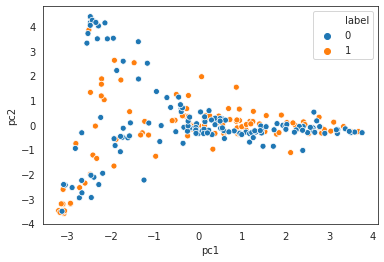

In [327]:
n_comp = 2
pca = PCA(n_components = n_comp)
components = pca.fit_transform(all_tta_outputs_reshaped)
# changed_reshaped = test_tta_outputs_preagg[:,changed,:]
# changed_reshaped = changed_reshaped.reshape((changed_reshaped.shape[1], 350))
# pca.fit(changed_reshaped)
#good_components = pca.transform(good_tta_outputs_reshaped)
#bad_components = pca.transform(bad_tta_outputs_reshaped)
#components = np.concatenate([good_components, bad_components])
if n_comp == 2:
    principalDf = pd.DataFrame(data = components
                , columns = ['pc1', 'pc2'])
    principalDf['label'] = labels_reshaped
    sns.scatterplot(x='pc1', y='pc2', hue='label', data=principalDf)
#print("AUC: ", roc_auc_score(labels_reshaped, np.linalg.norm(components, axis=1)))

# Constructing a PCA rule

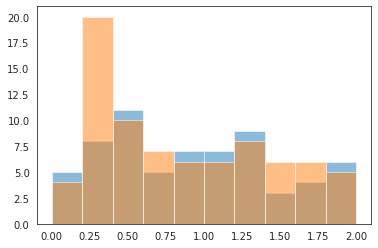

In [328]:
plt.hist(np.linalg.norm(components[np.where(np.array(labels_reshaped) == 1)[0]], axis=1),
         alpha=.5, range=[0, 2])
plt.hist(np.linalg.norm(components[np.where(np.array(labels_reshaped) == 0)[0]], axis=1), 
         alpha=.5, range=[0, 2])
if -1 in labels_reshaped:
    plt.hist(np.linalg.norm(components[np.where(np.array(labels_reshaped) == -1)[0]], axis=1), 
             alpha=.5, range=[0, 2])



# SVM Classifier

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
X = all_tta_outputs_reshaped
y = labels_reshaped

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
svm = SVC(kernel='rbf',  class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.7386363636363636

In [330]:
components_norm = np.linalg.norm(components, axis=1)
greater_than_1 = np.where(components_norm > 1)[0]
labels_reshaped = np.array(labels_reshaped)
n_ones = len(np.where(labels_reshaped[list(greater_than_1)] == 1)[0])
n_zeros = len(np.where(labels_reshaped[list(greater_than_1)] == 0)[0])
print(n_ones, n_zeros, n_ones - n_zeros)
n_improved_pca = n_ones - n_zeros

84 94 -10


# Unsupervised t-SNE rule

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 261 samples in 0.006s...
[t-SNE] Computed neighbors for 261 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 261 / 261
[t-SNE] Mean sigma: 2.413496
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.032143
[t-SNE] KL divergence after 300 iterations: 0.509890
AUC:  0.5214539007092198


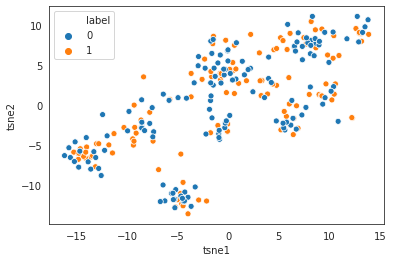

In [331]:
from sklearn.manifold import TSNE

n_comp = 2
tsne = TSNE(n_components=n_comp, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_tta_outputs_reshaped)
if -1 not in labels_reshaped:
    print("AUC: ", roc_auc_score(labels_reshaped, np.linalg.norm(tsne_results, axis=1)))
if n_comp ==2 :
    principalDf = pd.DataFrame(data = tsne_results
                , columns = ['tsne1', 'tsne2'])
    principalDf['label'] = labels_reshaped
    sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=principalDf)

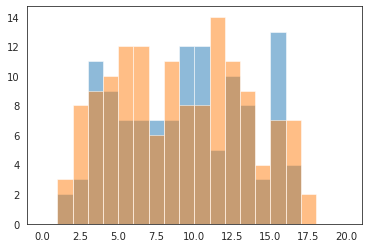

In [332]:
plt.hist(np.linalg.norm(tsne_results[np.where(np.array(labels_reshaped) == 1)[0]], axis=1),
         alpha=.5, range=[0, 20], bins=20)
plt.hist(np.linalg.norm(tsne_results[np.where(np.array(labels_reshaped) == 0)[0]], axis=1), 
         alpha=.5, range=[0, 20], bins=20)
if -1 in labels_reshaped:
    plt.hist(np.linalg.norm(components[np.where(np.array(labels_reshaped) == -1)[0]], axis=1), 
             alpha=.5, range=[0, 2])

In [333]:
tsne_norm = np.linalg.norm(tsne_results, axis=1)
greater_than_1 = np.where(tsne_norm > 5)[0]
n_ones = len(np.where(labels_reshaped[list(greater_than_1)] == 1)[0])
n_zeros = len(np.where(labels_reshaped[list(greater_than_1)] == 0)[0])
print(n_ones, n_zeros, n_ones - n_zeros)
n_tsne_improved = n_ones - n_zeros

95 111 -16


# Looking @ probability simplices

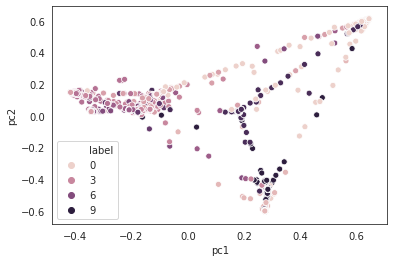

In [334]:
n_comp = 2
class_choice = 4
class_idxs = np.where(labels == class_choice)[0]
class_idxs = np.arange(len(labels))
pca = PCA(n_components=n_comp)
pca_results = pca.fit_transform(orig_outputs[class_idxs])

if n_comp ==2 :
    principalDf = pd.DataFrame(data = pca_results
                , columns = ['pc1', 'pc2'])
    principalDf['label'] = labels
    sns.scatterplot(x='pc1', y='pc2', hue='label', data=principalDf)

[0.11375236 0.11345363]


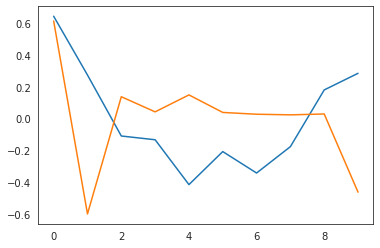

In [335]:
[plt.plot(pca.components_[i]) for i in range(n_comp)]
print(pca.explained_variance_ratio_)

# Could try training PCA/t-SNE on original test distribution outputs, and applying to each augmentation at test time

In [336]:
n_comp = 5
pca = PCA(n_components = n_comp)
components = pca.fit_transform(orig_outputs)

In [337]:
n_augs = good_test_tta_outputs.shape[1]

gg = good_test_tta_outputs.reshape((n_augs * n_correct, n_classes))
bb = bad_test_tta_outputs.reshape((n_augs*n_corrupt, n_classes))
gg_comp = pca.transform(gg)
bb_comp = pca.transform(bb)
gg_comp = gg_comp.reshape((n_augs, n_correct, n_comp))
bb_comp = bb_comp.reshape((n_augs, n_corrupt, n_comp))
gg_comp = gg_comp.reshape((n_correct, n_augs*n_comp))
bb_comp = bb_comp.reshape((n_corrupt, n_augs*n_comp))

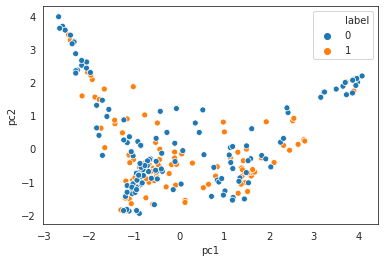

In [338]:
n_comp = 2
pca_comp = PCA(n_components = n_comp)
ggbb_comps = pca_comp.fit_transform(np.concatenate([gg_comp, bb_comp]))
principalDf = pd.DataFrame(data = ggbb_comps
            , columns = ['pc1', 'pc2'])
principalDf['label'] = labels_reshaped
sns.scatterplot(x='pc1', y='pc2', hue='label', data=principalDf)

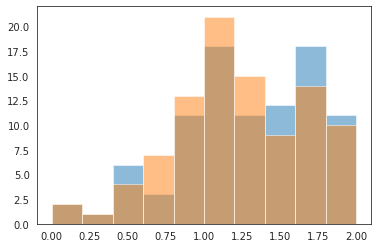

In [339]:
plt.hist(np.linalg.norm(ggbb_comps[np.where(np.array(labels_reshaped) == 1)[0]], axis=1),
         alpha=.5, range=[0, 2])
plt.hist(np.linalg.norm(ggbb_comps[np.where(np.array(labels_reshaped) == 0)[0]], axis=1), 
         alpha=.5, range=[0, 2])
if -1 in labels_reshaped:
    plt.hist(np.linalg.norm(ggbb_comps[np.where(np.array(labels_reshaped) == -1)[0]], axis=1), 
             alpha=.5, range=[0, 2])


In [340]:
ggbb_comps_norm = np.linalg.norm(ggbb_comps, axis=1)
greater_than_1 = np.where(ggbb_comps_norm > 1)[0]
labels_reshaped = np.array(labels_reshaped)
n_ones = len(np.where(labels_reshaped[list(greater_than_1)] == 1)[0])
n_zeros = len(np.where(labels_reshaped[list(greater_than_1)] == 0)[0])
print(n_ones, n_zeros, n_ones - n_zeros)
n_simplex_improved = n_ones - n_zeros

97 114 -17


In [341]:
print("Original: ", n_orig_improved)
print("PCA: ", n_improved_pca)
print("t-SNE: ", n_tsne_improved)
print("training simplex: ", n_simplex_improved)

Original:  -21
PCA:  -10
t-SNE:  -16
training simplex:  -17


Text(0.5, 1.0, 'Net # of Corrections (# Corrections - # Corruptions)')

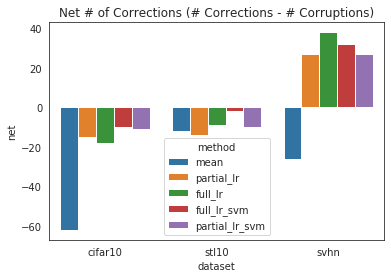

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
label_flip_df = pd.read_csv('label_flip_results')
label_flip_df['net'] = label_flip_df['n_correct'] - label_flip_df['n_corrupt']
y_col = 'net'

sns.barplot(x='dataset', y=y_col, hue='method', data=label_flip_df)
title = "Net # of Corrections (# Corrections - # Corruptions)"
if 'corrupt' in y_col:
    title = "# of Corruptions"
elif 'correct' in y_col:
    title = "# of Corrections"
plt.title(title)

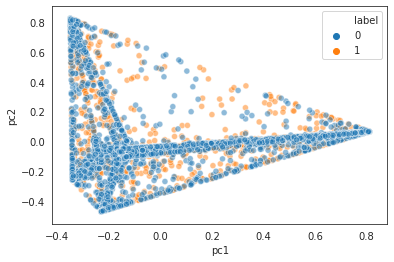

In [343]:
n_correct, n_augs, n_classes = good_test_tta_outputs.shape
n_corrupt, _, _ = bad_test_tta_outputs.shape

good_examples = good_test_tta_outputs.reshape((n_correct*n_augs, n_classes))
bad_examples = bad_test_tta_outputs.reshape((n_corrupt*n_augs, n_classes))
all_examples = np.concatenate([good_examples, bad_examples], axis=0)
labels_expanded = np.array([1 for i in range(n_correct*n_augs)] + [0 for i in range(n_corrupt*n_augs)])
n_comp = 2
pca_comp = PCA(n_components = n_comp)
ggbb_comps = pca_comp.fit_transform(all_examples)
principalDf = pd.DataFrame(data = ggbb_comps
            , columns = ['pc1', 'pc2'])
principalDf['label'] = labels_expanded
sns.scatterplot(x='pc1', y='pc2', hue='label', data=principalDf, alpha=.5)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9135 samples in 0.033s...
[t-SNE] Computed neighbors for 9135 samples in 1.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9135
[t-SNE] Computed conditional probabilities for sample 2000 / 9135
[t-SNE] Computed conditional probabilities for sample 3000 / 9135
[t-SNE] Computed conditional probabilities for sample 4000 / 9135
[t-SNE] Computed conditional probabilities for sample 5000 / 9135
[t-SNE] Computed conditional probabilities for sample 6000 / 9135
[t-SNE] Computed conditional probabilities for sample 7000 / 9135
[t-SNE] Computed conditional probabilities for sample 8000 / 9135
[t-SNE] Computed conditional probabilities for sample 9000 / 9135
[t-SNE] Computed conditional probabilities for sample 9135 / 9135
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.917732
[t-SNE] KL divergence after 300 iterations: 1.908807
AUC:  0.5040829353017804


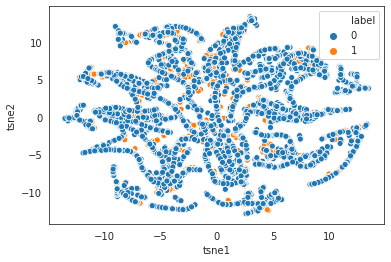

In [344]:
from sklearn.manifold import TSNE

n_comp = 2
tsne = TSNE(n_components=n_comp, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_examples)
if -1 not in labels_reshaped:
    print("AUC: ", roc_auc_score(labels_expanded, np.linalg.norm(tsne_results, axis=1)))
if n_comp ==2 :
    principalDf = pd.DataFrame(data = tsne_results
                , columns = ['tsne1', 'tsne2'])
    principalDf['label'] = labels_expanded
    sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=principalDf)

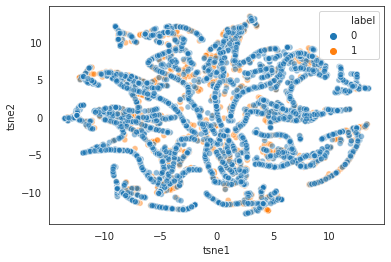

In [345]:
principalDf = pd.DataFrame(data = tsne_results , columns = ['tsne1', 'tsne2'])
principalDf['label'] = labels_expanded
sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=principalDf, alpha=.5)

In [346]:
X = all_examples
y = labels_expanded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
svm = SVC(kernel='rbf',  class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.6295251237728632

In [347]:
good_preds = svm.predict_proba(good_examples)[:,1]
bad_preds = svm.predict_proba(bad_examples)[:,1]
good_preds = good_preds.reshape((n_correct, n_augs))
bad_preds = bad_preds.reshape((n_corrupt, n_augs))


(array([37.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 10 Patch objects>)

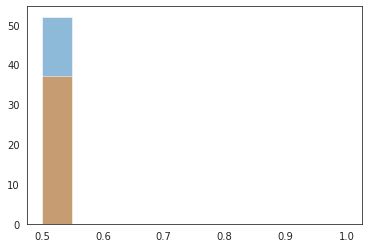

In [348]:
plt.hist(np.mean(good_preds, axis=1), alpha=.5, range=[.5, 1.0])
plt.hist(np.mean(bad_preds, axis=1), alpha=.5, range=[.5, 1.0])

In [349]:
good_preds.shape

(120, 35)

In [350]:
good_examples.shape

(4200, 10)